In [41]:
import tensorflow as tf
from tensorflow.keras import layers, models
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import shutil
import glob
from tqdm import tqdm
import random
import pickle

In [42]:
# Paths
raw_dir = r'C:\Users\addit\OneDrive\Desktop\Drowsiness\mrlEyes_2018_01\mrlEyes_2018_01'
train_dir = r'C:\Users\addit\OneDrive\Desktop\Drowsiness\Train_Dataset'
test_dir = r'C:\Users\addit\OneDrive\Desktop\Drowsiness\Test_Dataset'
closed_eyes_dir = os.path.join(train_dir, "Closed_Eyes")
open_eyes_dir = os.path.join(train_dir, "Open_Eyes")

# Prepare directories
os.makedirs(closed_eyes_dir, exist_ok=True)
os.makedirs(open_eyes_dir, exist_ok=True)

In [3]:
# Copy images to corresponding directories
for dirpath, dirname, filenames in os.walk(raw_dir):
    for filename in tqdm([f for f in filenames if f.endswith('.png')]):
        src = os.path.join(dirpath, filename)
        if filename.split('_')[4] == '0':
            dst = os.path.join(closed_eyes_dir, filename)
        else:
            dst = os.path.join(open_eyes_dir, filename)
        shutil.copy(src, dst)

0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████| 10257/10257 [01:44<00:00, 98.17it/s]


In [43]:
# Image preprocessing
def load_and_preprocess_image(path, img_size=224):
    img_array = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img_rgb = cv2.cvtColor(img_array, cv2.COLOR_GRAY2RGB)
    resized_img = cv2.resize(img_rgb, (img_size, img_size))
    return resized_img

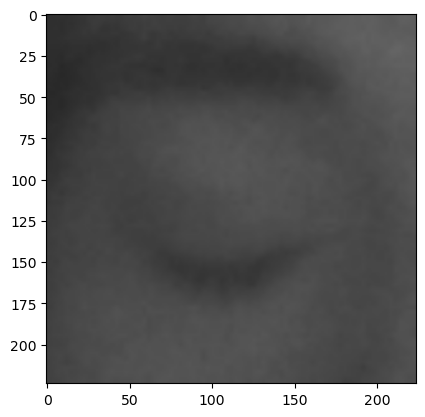

In [44]:
# Display a sample image
#sample_img_path = os.path.join(closed_eyes_dir, "C:\Users\addit\OneDrive\Desktop\Drowsiness\Test_Dataset\Closed_Eyes\s0001_00005_0_0_0_0_0_01.png")
sample_img_path = os.path.join(closed_eyes_dir, r"C:\Users\addit\OneDrive\Desktop\Drowsiness\Test_Dataset\Closed_Eyes\s0001_00005_0_0_0_0_0_01.png")
sample_img = load_and_preprocess_image(sample_img_path)
plt.imshow(sample_img)
plt.show()

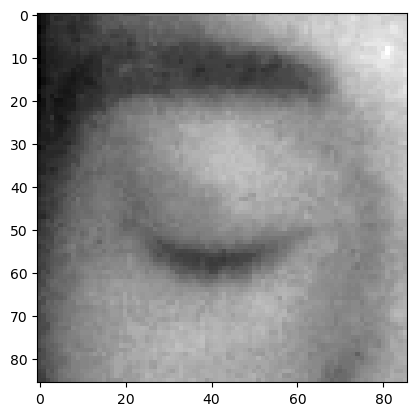

In [45]:
Datadirectory = "Test_Dataset/" ## training dataset 
Classes = ["Closed_Eyes","Open_Eyes"] ## List of classes
for category in Classes:
    path= os.path.join(Datadirectory, category) ## //
    for img in os.listdir (path):
        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
        backtorgb= cv2.cvtColor(img_array,cv2.COLOR_GRAY2RGB)
        plt.imshow(img_array, cmap="gray")
        plt.show()
        break
    break

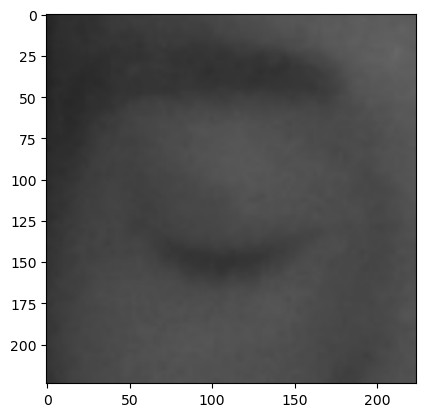

In [46]:
img_size = 224

new_array = cv2.resize(backtorgb, (img_size,img_size))
plt.imshow(new_array, cmap = "gray")
plt.show()

In [47]:
training_Data = []

def create_training_Data():
    for category in Classes:
        path = os.path.join(Datadirectory, category)  # Define path here
        class_num = Classes.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                backtorgb = cv2.cvtColor(img_array, cv2.COLOR_GRAY2RGB)
                new_array = cv2.resize(backtorgb, (img_size, img_size))
                training_Data.append([new_array, class_num])
            except Exception as e:
                pass

In [48]:
create_training_Data()

In [49]:
print(len(training_Data))

1323


In [50]:
random.shuffle(training_Data)
X =[]
y= []

for features,label in training_Data: 
    X.append(features) 
    y.append(label)

X = np.array(X).reshape(-1,img_size,img_size,3)

In [51]:
X.shape

(1323, 224, 224, 3)

In [52]:
X= X/255.0 #Normalize the data
Y = np.array(y)

In [53]:
# Save X data to a pickle file
pickle_out = open("X.pickle", "wb")
pickle.dump(X, pickle_out)
pickle_out.close()

# Save y data to a pickle file
pickle_out = open("y.pickle", "wb")
pickle.dump(y, pickle_out)
pickle_out.close()

In [54]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [55]:
# Model construction
base_model = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
flat_layer = layers.Flatten()(base_model.output)
output_layer = layers.Dense(1, activation='linear')(flat_layer)  # Linear activation for positive/negative output

model = models.Model(inputs=base_model.input, outputs=output_layer)
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,279,041 (12.51 MB)

 Trainable params: 3,257,153 (12.43 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [56]:
# Compile and train model
model.compile(loss="mean_squared_error", optimizer="adam", metrics=['accuracy'])  # Use mean squared error for linear output
history = model.fit(X,Y,epochs=1, validation_split=0.1)

38/38 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.5090 - loss: 144.3613 - val_accuracy: 0.4812 - val_loss: 219.4725


In [57]:
# Save model
model.save('my_model.h5')

In [58]:
# Load and test the model
new_model = tf.keras.models.load_model('my_model.h5')
model.compile(loss="mean_squared_error", optimizer="adam", metrics=['accuracy'])
test_img_path = r"C:\Users\addit\OneDrive\Desktop\Drowsiness\Test_Dataset\Open_Eyes\s0001_01843_0_0_1_0_0_01.png"
test_img = load_and_preprocess_image(test_img_path, img_size)
test_img = np.expand_dims(test_img, axis=0) / 255.0
prediction = new_model.predict(test_img)
print(f"Prediction: {'Open Eyes' if prediction > 0 else 'Closed Eyes'}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step
Prediction: Open Eyes


In [90]:
def detect_eyes():
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        raise IOError("Cannot open webcam")

    while True:
        ret, frame = cap.read()
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        eyes = eye_cascade.detectMultiScale(gray, 1.1, 4)
        status = "No Eyes Detected"

        for (x, y, w, h) in eyes:
            roi_gray = gray[y:y+h, x:x+w]
            roi_color = frame[y:y+h, x:x+w]
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
            final_img = cv2.resize(roi_color, (224, 224))
            final_img = np.expand_dims(final_img, axis=0) / 255.0
            prediction = new_model.predict(final_img)
            status = "Open Eyes" if prediction > 0 else "Closed Eyes"

        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(frame, status, (50, 50), font, 1, (0, 0, 255), 2, cv2.LINE_4)
        cv2.imshow('Drowsiness Detection', frame)
        
      
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

detect_eyes()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━

In [94]:
import cv2
import numpy as np
import pygame

def detect_eyes():
    pygame.mixer.init()
    alarm_sound = pygame.mixer.Sound("music.wav")  
    
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        raise IOError("Cannot open webcam")

    eyes_closed_time = 0 
    
    while True:
        ret, frame = cap.read()
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        eyes = eye_cascade.detectMultiScale(gray, 1.1, 4)
        status = "No Eyes Detected"

        if len(eyes) == 0:
            eyes_closed_time += 1
            if eyes_closed_time > 50: 
                alarm_sound.play() 
        else:
            eyes_closed_time = 0 
        
        for (x, y, w, h) in eyes:
            roi_gray = gray[y:y+h, x:x+w]
            roi_color = frame[y:y+h, x:x+w]
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
            final_img = cv2.resize(roi_color, (224, 224))
            final_img = np.expand_dims(final_img, axis=0) / 255.0
            prediction = new_model.predict(final_img)
            status = "Open Eyes" if prediction > 0 else "Closed Eyes"

        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(frame, status, (50, 50), font, 1, (0, 0, 255), 2, cv2.LINE_4)
        cv2.imshow('Drowsiness Detection', frame)
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

detect_eyes()


error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [95]:
import cv2
import numpy as np
import pygame

def detect_eyes():
    # Initialize pygame for playing sounds
    pygame.mixer.init()
    alarm_sound = pygame.mixer.Sound("music.wav")  # Replace "alarm.wav" with your alarm sound file
    
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        raise IOError("Cannot open webcam")

    eyes_closed_time = 0  # Initialize the timer for closed eyes
    
    while True:
        ret, frame = cap.read()
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        eyes = eye_cascade.detectMultiScale(gray, 1.1, 4)
        status = "No Eyes Detected"

        if len(eyes) == 0:
            eyes_closed_time += 1
            if eyes_closed_time > 50:  # If eyes are closed for more than 2 seconds (50 frames at 25 fps)
                alarm_sound.play()  # Play the alarm sound
        else:
            eyes_closed_time = 0  # Reset the timer if eyes are open
        
        for (x, y, w, h) in eyes:
            roi_gray = gray[y:y+h, x:x+w]
            roi_color = frame[y:y+h, x:x+w]
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
            final_img = cv2.resize(roi_color, (224, 224))
            final_img = np.expand_dims(final_img, axis=0) / 255.0
            prediction = new_model.predict(final_img)
            status = "Open Eyes" if prediction > 0 else "Closed Eyes"

        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(frame, status, (50, 50), font, 1, (0, 0, 255), 2, cv2.LINE_4)
        cv2.imshow('Drowsiness Detection', frame)
        
        # Break the loop when 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

detect_eyes()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━